In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from IPython.display import Image
import matplotlib.image as mpimg
from scipy import stats

# POB and POR and sampling center location
__Partition into groups with respect to sampling center location__  

`
close,close     (well-sampled?)  
close,far       (under-sampled?)  
far,close       (over-sampled?)  
far, far        (under-sampled?)  `

Four lists of eids: close, por_close, pob_close, far

In [2]:
# functions:
def coords_to_distance(p1,p2):
    return math.hypot(p2[0]-p1[0],p2[1]-p1[1])

def center_proximity(df,ac_distance_threshold): # also include movement thresholds?
    pob_close = df[df['POB_distance'] <= ac_distance_threshold].index.values
    pob_far = df[df['POB_distance'] > ac_distance_threshold].index.values
    por_close = df[df['POR_distance'] <= ac_distance_threshold].index.values
    por_far = df[df['POR_distance'] > ac_distance_threshold].index.values
    close = set(pob_close) & set(por_close)
    far = set(pob_far) & set(por_far)
    pob_close = set(pob_close) & set(por_far)
    por_close = set(por_close) & set(pob_far)
    # returns list of indices for each group
    return [list(x) for x in [close,pob_close,por_close,far]]

def movers_nonmovers(df,distance_threshold):
    movers = df[df['distances'] >= distance_threshold].index.values
    nonMovers = df[df['distances'] < distance_threshold].index.values
    return movers, nonMovers

def plot_move_groups(moveGroups,move_distance,center_distance):
    labs = ['close_move','close_stay','pob_close_move','pob_close_stay','por_close_move','por_close_stay',
       'far_move','far_stay']
    cols = ['r','b','r','b','r','b','r','b']
    moveCounts = [len(x) for x in moveGroups]
    ind = np.arange(len(moveCounts))+1
    fig,ax = plt.subplots(1,1, figsize=(14,6))
    bars = ax.bar(ind,moveCounts)
    for i,b in enumerate(bars):
        b.set_facecolor(cols[i])
    titleText = str(center_distance/1000) + ' (km) to center; ' + str(move_distance/1000) + ' pob to por'
    ax.set_title(titleText,fontsize=16)
    ax.set_xticks(ind)
    ax.set_xticklabels(labs)
    ax.set_ylabel('Number of UKB samples', fontsize=16)
    plt.show()
    
def collect_move_groups(df,move_distance,center_distance,showPlot = False):
    m,n = movers_nonmovers(df,move_distance)
    c,b,r,f = center_proximity(df,center_distance)
    cm = list(set(c) & set(m))
    cn = list(set(c) & set(n))
    bm = list(set(b) & set(m))
    bn = list(set(b) & set(n))
    rm = list(set(r) & set(m))
    rn = list(set(r) & set(n))
    fm = list(set(f) & set(m))
    fn = list(set(f) & set(n))
    moveGroups = [cm, cn, bm, bn, rm, rn, fm, fn]
    if showPlot == True:
        plot_move_groups(moveGroups,move_distance,center_distance)
    return moveGroups

def get_ncolors_from_cmap(num_colors,colormap='viridis'):
    cmap = cm.get_cmap(colormap)
    cols = [cmap(x) for x in np.linspace(0,1,num_colors)]
    return cols

In [3]:
## Load data
# pob_por derived from eid_data and only includes individuals with both POB and POR locations
# pob_locations.csv has complete POB dataset, including sampling centers
pob_por = pd.read_csv('../00_csv_files/pob_por_ac_distances.csv')
ac = pd.read_csv('../00_csv_files/assessmentCentreCoordinates.csv')

In [4]:
ac

,Name,Count,East,North,Code
0,Barts,12582,531807,181602,11012
1,Birmingham,25501,406790,287314,11021
2,Bristol,43012,359469,172551,11011
3,Bury,28322,380313,410782,11008
4,Cardiff,17878,317841,176760,11003
5,Croydon,27381,531544,165489,11020
6,Edinburgh,17198,325764,673964,11005
7,Glasgow,18647,259106,665369,11004
8,Hounslow,28875,512863,175510,11018
9,Leeds,44199,429691,433831,11010


In [5]:
# make dictionary: assessment center code => [east,north]
ac_coords = {}
for i,r in ac.iterrows():
    c = r['Code']
    e = r['East']
    n = r['North']
    
    ac_coords[c] = [e,n]

In [6]:
pob_por.head(5)

,eid,center,distances,POB_east,POB_north,POR_east,POR_north,POB_distance,POR_distance,closest_center,POR_distance_closest,POB_distance_closest
0,1136349,11004,229901.065678,68500,801500,252000.0,663000.0,234227.018930,7490.487100,11004.0,7490.487100,234227.018930
1,1071275,11004,196729.509734,66500,798500,211000.0,665000.0,234138.707601,48107.415198,11004.0,48107.415198,234138.707601
2,4778319,11005,287336.910264,66500,798500,323000.0,669000.0,287623.081466,5681.636384,11005.0,5681.636384,287623.081466
3,2797312,11011,726962.516228,79500,842500,358000.0,171000.0,726095.244140,2136.249517,11011.0,2136.249517,726095.244140
4,3735126,11002,741907.339228,79500,842500,459000.0,205000.0,736902.470402,7866.440364,11002.0,7866.440364,736902.470402


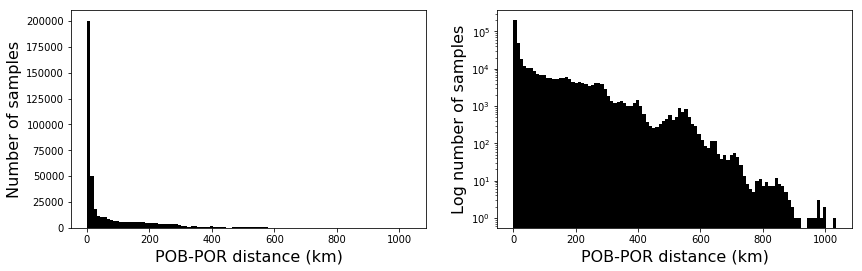

In [7]:
fig,ax = plt.subplots(1,2,figsize = (14,4))
ax1 = ax[0]
ax1.hist(pob_por['distances']/1000,100,color='k')
ax1.set_ylabel('Number of samples',fontsize = 16)
ax1.set_xlabel('POB-POR distance (km)',fontsize = 16)

ax2 = ax[1]
ax2.hist(pob_por['distances']/1000,100,color='k')
ax2.set_yscale('log')
ax2.set_ylabel('Log number of samples',fontsize = 16)
ax2.set_xlabel('POB-POR distance (km)',fontsize = 16)
plt.show()

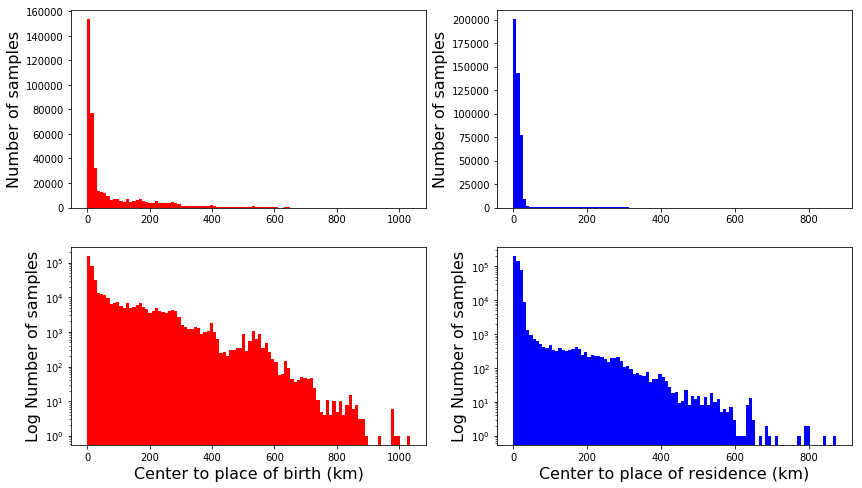

In [8]:
fig,ax = plt.subplots(2,2,figsize = (14,8))

ax1 = ax[0,0]
ax1.hist(pob_por['POB_distance']/1000,100,color='r')
ax1.set_ylabel('Number of samples',fontsize = 16)
#ax1.set_xlabel('Center to place of birth (km)',fontsize=16)

ax2 = ax[0,1]
ax2.hist(pob_por['POR_distance']/1000,100,color='b')
ax2.set_ylabel('Number of samples',fontsize = 16)
#ax2.set_xlabel('Center to place of residence (km)',fontsize=16)

ax3 = ax[1,0]
ax3.hist(pob_por['POB_distance']/1000,100,color='r')
ax3.set_yscale('log')
ax3.set_ylabel('Log Number of samples',fontsize = 16)
ax3.set_xlabel('Center to place of birth (km)',fontsize=16)

ax4 = ax[1,1]
ax4.set_yscale('log')
ax4.hist(pob_por['POR_distance']/1000,100,color='b')
ax4.set_ylabel('Log Number of samples',fontsize = 16)
ax4.set_xlabel('Center to place of residence (km)',fontsize=16)

plt.show()

0.9441389703486478
0.5668920386662322


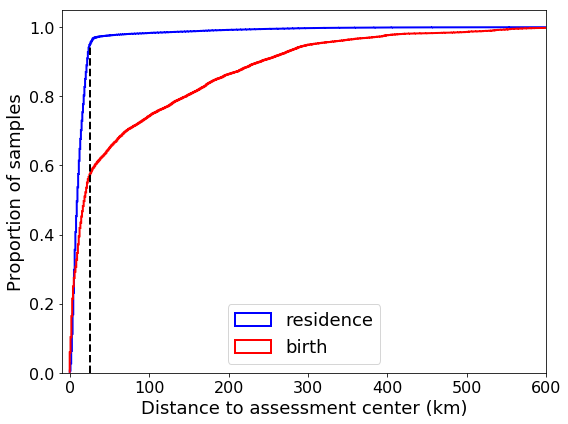

In [32]:
f,a = plt.subplots(1,1,figsize=(8,6))

# POR distance to assessment center, BLUE
d = pob_por['POR_distance'] / 1000
a.hist(d, 1000, density=True, histtype='step', cumulative=True, color='b', linewidth = 2, label = 'residence')

# POB distance to assessment center, RED
d = pob_por['POB_distance'] / 1000
a.hist(d, 1000, density=True, histtype='step', cumulative=True, color='r', linewidth = 2, label = 'birth')

# # all kin POB, RED
# d = pob_nearest_dist
# d = d[~np.isnan(d)] / 1000
# a.hist(d, 1000, density=True, histtype='step', cumulative=True, color='r', linewidth = 2, label = 'pob')

maxX = 650
a.set_xlim([-10,600])
a.set_xticks(np.arange(0,maxX,100))
a.legend(prop={'size': 18}, loc = 'lower center')
a.set_xlabel('Distance to assessment center (km)',fontsize=18)
a.set_ylabel('Proportion of samples',fontsize=18)
a.tick_params(axis='both', which='major', labelsize=16)

i=25
por_at_i = len(pob_por[pob_por['POR_distance'] <= i * 1000]) / float(len(pob_por))
pob_at_i = len(pob_por[pob_por['POB_distance'] <= i * 1000]) / float(len(pob_por))
a.plot([i,i],[0,por_at_i],'--k',linewidth = 2)
print(por_at_i)
print(pob_at_i)
plt.tight_layout()
plt.savefig('../07_figures/Figure_01_sampling_AC/cumulative_ac_distance.png', dpi = 150)
plt.show()

### How many UKB samples are in these four categories?
close = both POB and POR within a distance threshold to an assessment center   
pob_close = POB within threshold, POR not  
por_close = POR within threshold, POB not  
far = neither POB and POR are within a distance threshold to an assessment center    

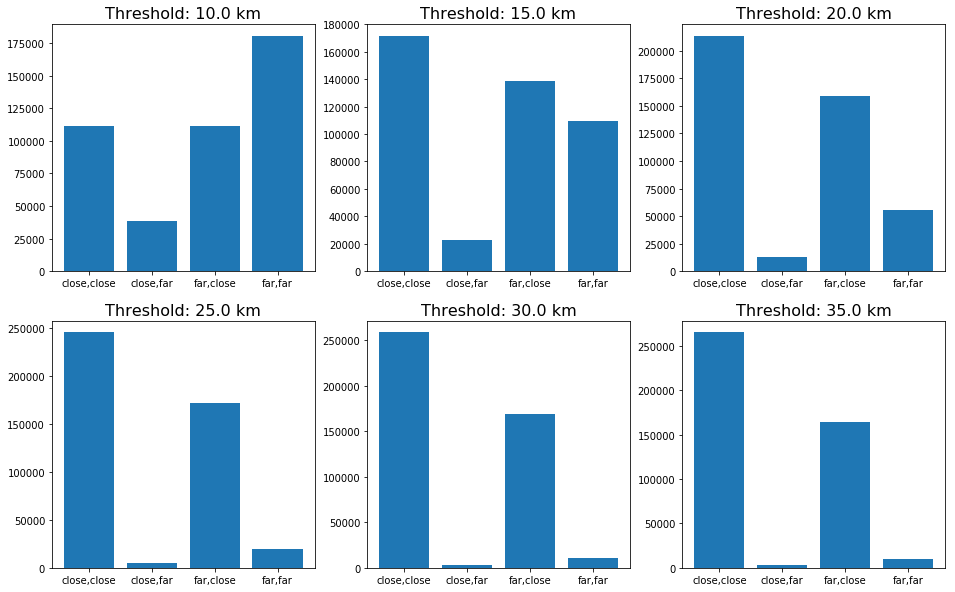

In [11]:
testD = [10000,15000,20000,25000,30000,35000]
labs = ['close,close','close,far','far,close','far,far']
fig = plt.figure(figsize=(16,10))
for i,t in enumerate(testD):
    ax = plt.subplot(2,3,i+1)
    proximity_groups = center_proximity(pob_por,t)
    vals = [len(x) for x in proximity_groups]
    #print(vals,t)
    ind = np.arange(len(vals))+1
    ax.bar(ind,vals)
    ax.set_title('Threshold: ' + str(t/1000) + ' km',fontsize=16)
    ax.set_xticks(ind)
    ax.set_xticklabels(labs)
    
plt.show()

### Try to be more systematic ... make a graph of cumulative proportion of UKB points that are
###  within X km of their sample center (or any sample center)

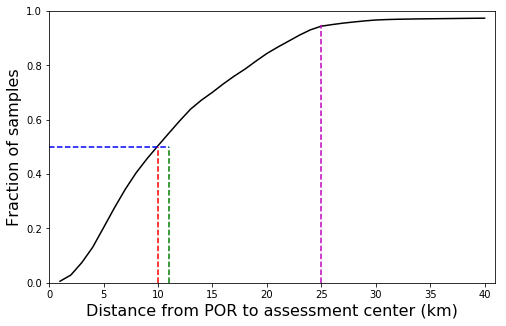

In [10]:
dkm = np.arange(1,41)
counts = np.zeros(len(dkm))
tot = float(len(pob_por))
for i in dkm:   
    counts[i-1] = len(pob_por[pob_por['POR_distance'] <= i * 1000]) / tot

f,ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(dkm,counts,'-k')
ax.set_ylim([0,1])
ax.set_xlim([0,41])
ax.set_ylabel('Fraction of samples',fontsize=16)
ax.set_xlabel('Distance from POR to assessment center (km)',fontsize=16)
ax.plot([0,11],[.5,.5],'--b')
ax.plot([10,10],[0,0.5],'--r')
ax.plot([11,11],[0,0.5],'--g')
ax.plot([25,25],[0,0.95],'--m')
plt.show()

In [12]:
i=20
print(len(pob_por[pob_por['POR_distance'] <= i * 1000]) / float(len(pob_por)))

0.843558795843742




### what is the closest sample center for each eid?

In [12]:
# ac_coords = dictionary of sampleCenter => [east,north]
def find_closest_ac(POR,ac_coords):
    d = 10000000
    for ac in ac_coords.keys():
        d_thisAC = coords_to_distance(POR,ac_coords[ac])
        if d_thisAC < d:
            d = d_thisAC
            closestAC = ac
    return closestAC

In [40]:
# find closest center and distance to it for POB and POR, also distance from POR to center sampled
df = pob_por
closestAC_POR = np.zeros(len(df))
closestAC_POB = np.zeros(len(df))
POR_distance = np.zeros(len(df))
POB_distance = np.zeros(len(df))
POR_distance_closest = np.zeros(len(df))

porE = dict(zip(pob_por.eid,pob_por.POR_east))
porN = dict(zip(pob_por.eid,pob_por.POR_north))
pobE = dict(zip(pob_por.eid,pob_por.POB_east))
pobN = dict(zip(pob_por.eid,pob_por.POB_north))
acDict = dict(zip(pob_por.eid,pob_por.center))

for i,eid in enumerate(porE.keys()):
    POR = [porE[eid],porN[eid]]
    POB = [pobE[eid],pobN[eid]]
    ac = acDict[eid]
    
    closestAC_POR[i] = find_closest_ac(POR,ac_coords)
    closestAC_POB[i] = find_closest_ac(POB,ac_coords)
    
    POR_distance_closest[i] = coords_to_distance(POR,ac_coords[closestAC_POR[i]])
    
    POR_distance[i] = coords_to_distance(POR,ac_coords[acDict[eid]])
    POB_distance[i] = coords_to_distance(POB,ac_coords[acDict[eid]])


In [41]:
pob_por['closest_center'] = closestAC_POR
pob_por['POR_distance_closest'] = POR_distance_closest
pob_por['POR_distance'] = POR_distance
pob_por['POB_distance'] = POB_distance
pob_por.head(5)

,eid,center,distances,POB_east,POB_north,POR_east,POR_north,POB_distance,POR_distance,closest_center,POR_distance_closest,POB_distance_closest
0,1136349,11004,229901.065678,68500,801500,252000.0,663000.0,234227.018930,7490.487100,11004.0,7490.487100,234227.018930
1,1071275,11004,196729.509734,66500,798500,211000.0,665000.0,234138.707601,48107.415198,11004.0,48107.415198,234138.707601
2,4778319,11005,287336.910264,66500,798500,323000.0,669000.0,287623.081466,5681.636384,11005.0,5681.636384,287623.081466
3,2797312,11011,726962.516228,79500,842500,358000.0,171000.0,726095.244139,2136.249517,11011.0,2136.249517,726095.244139
4,3735126,11002,741907.339228,79500,842500,459000.0,205000.0,736902.470402,7866.440364,11002.0,7866.440364,736902.470402


In [30]:
sampleCenter = pob_por['center'].values.tolist()
closestCenter = pob_por['closest_center'].values.tolist()
sampleCenterClosest = 0
sampleCenterNotClosest = 0
notCloseInd = []
for i,c in enumerate(sampleCenter):
    if c == closestCenter[i]:
        sampleCenterClosest += 1
    else:
        sampleCenterNotClosest += 1
        notCloseInd.append(i)
print(sampleCenterClosest,sampleCenterNotClosest)

410992 30944


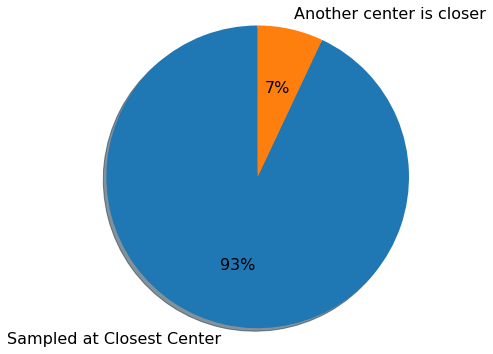

In [31]:
# Pie chart
labels = 'Sampled at Closest Center', 'Another center is closer'
sizes = [sampleCenterClosest,sampleCenterNotClosest]

fig1, ax1 = plt.subplots(figsize = (6,6))
ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90, textprops={'size': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

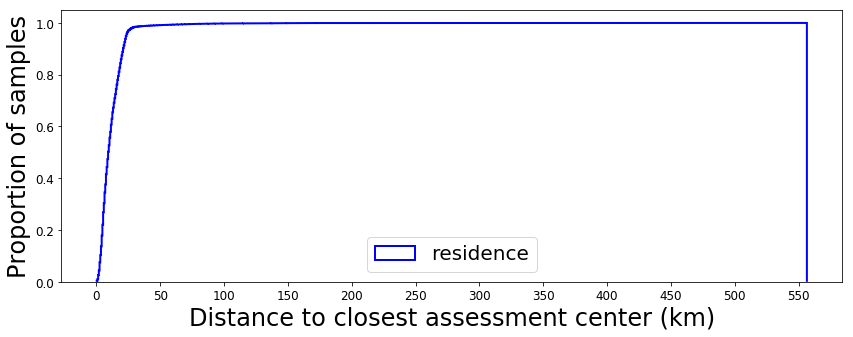

In [15]:
f,a = plt.subplots(1,1,figsize=(14,5))

# POR distance to assessment center, BLUE
d = pob_por['POR_distance_closest'] / 1000
a.hist(d, 1000, density=True, histtype='step', cumulative=True, color='b', linewidth = 2, label = 'residence')

maxX = 600
a.set_xticks(np.arange(0,maxX,50))
a.legend(prop={'size': 20}, loc = 'lower center')
a.set_xlabel('Distance to closest assessment center (km)',fontsize=24)
a.set_ylabel('Proportion of samples',fontsize=24)
a.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [16]:
i=25
print(len(pob_por[pob_por['POR_distance_closest'] <= i * 1000]) / float(len(pob_por)))

0.9684909127113428


# movers vs non-movers

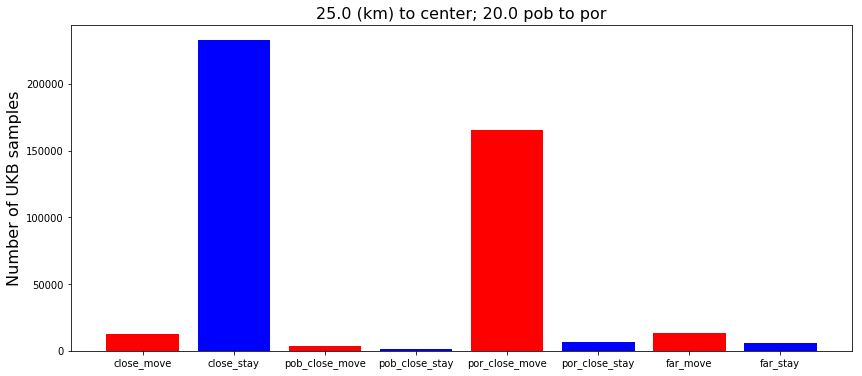

[12513, 232606, 3902, 1509, 165267, 6863, 13566, 5710]


In [17]:
# now, separate the movers from the non-movers in each category
# see POB_POR_migration.ipynb for rationale behind 20km
centerDistanceThreshold = 25000
moveThreshold = 20000
moveGroups = collect_move_groups(pob_por,moveThreshold,centerDistanceThreshold,True)
groupSizes = ([len(x) for x in moveGroups])
print(groupSizes)

In [18]:
# I have indices from pob_por for UKB points in each of these 8 groups
# now, convert these into eids
eidGroups = []
for i,g in enumerate(moveGroups):
    eidGroups.append(pob_por[pob_por.index.isin(moveGroups[i])]['eid'].values.tolist())

In [19]:
# only include some groups
eidGroups = [eidGroups[1],eidGroups[4],eidGroups[7],eidGroups[6]]
grouplabels = ['stay_ac','move_to_ac','far_stay','far_move']

### Mapping the move / stay groups

In [20]:
stay_ac = pob_por[pob_por['eid'].isin(eidGroups[0])]
move_to_ac = pob_por[pob_por['eid'].isin(eidGroups[1])]
far_stay = pob_por[pob_por['eid'].isin(eidGroups[2])]
far_move = pob_por[pob_por['eid'].isin(eidGroups[3])]

In [21]:
stay_ac.to_csv('../00_csv_files/stay_ac.csv',index=False)
move_to_ac.to_csv('../00_csv_files/move_to_ac.csv',index=False)
far_stay.to_csv('../00_csv_files/far_stay.csv',index=False)
far_move.to_csv('../00_csv_files/far_move.csv',index=False)

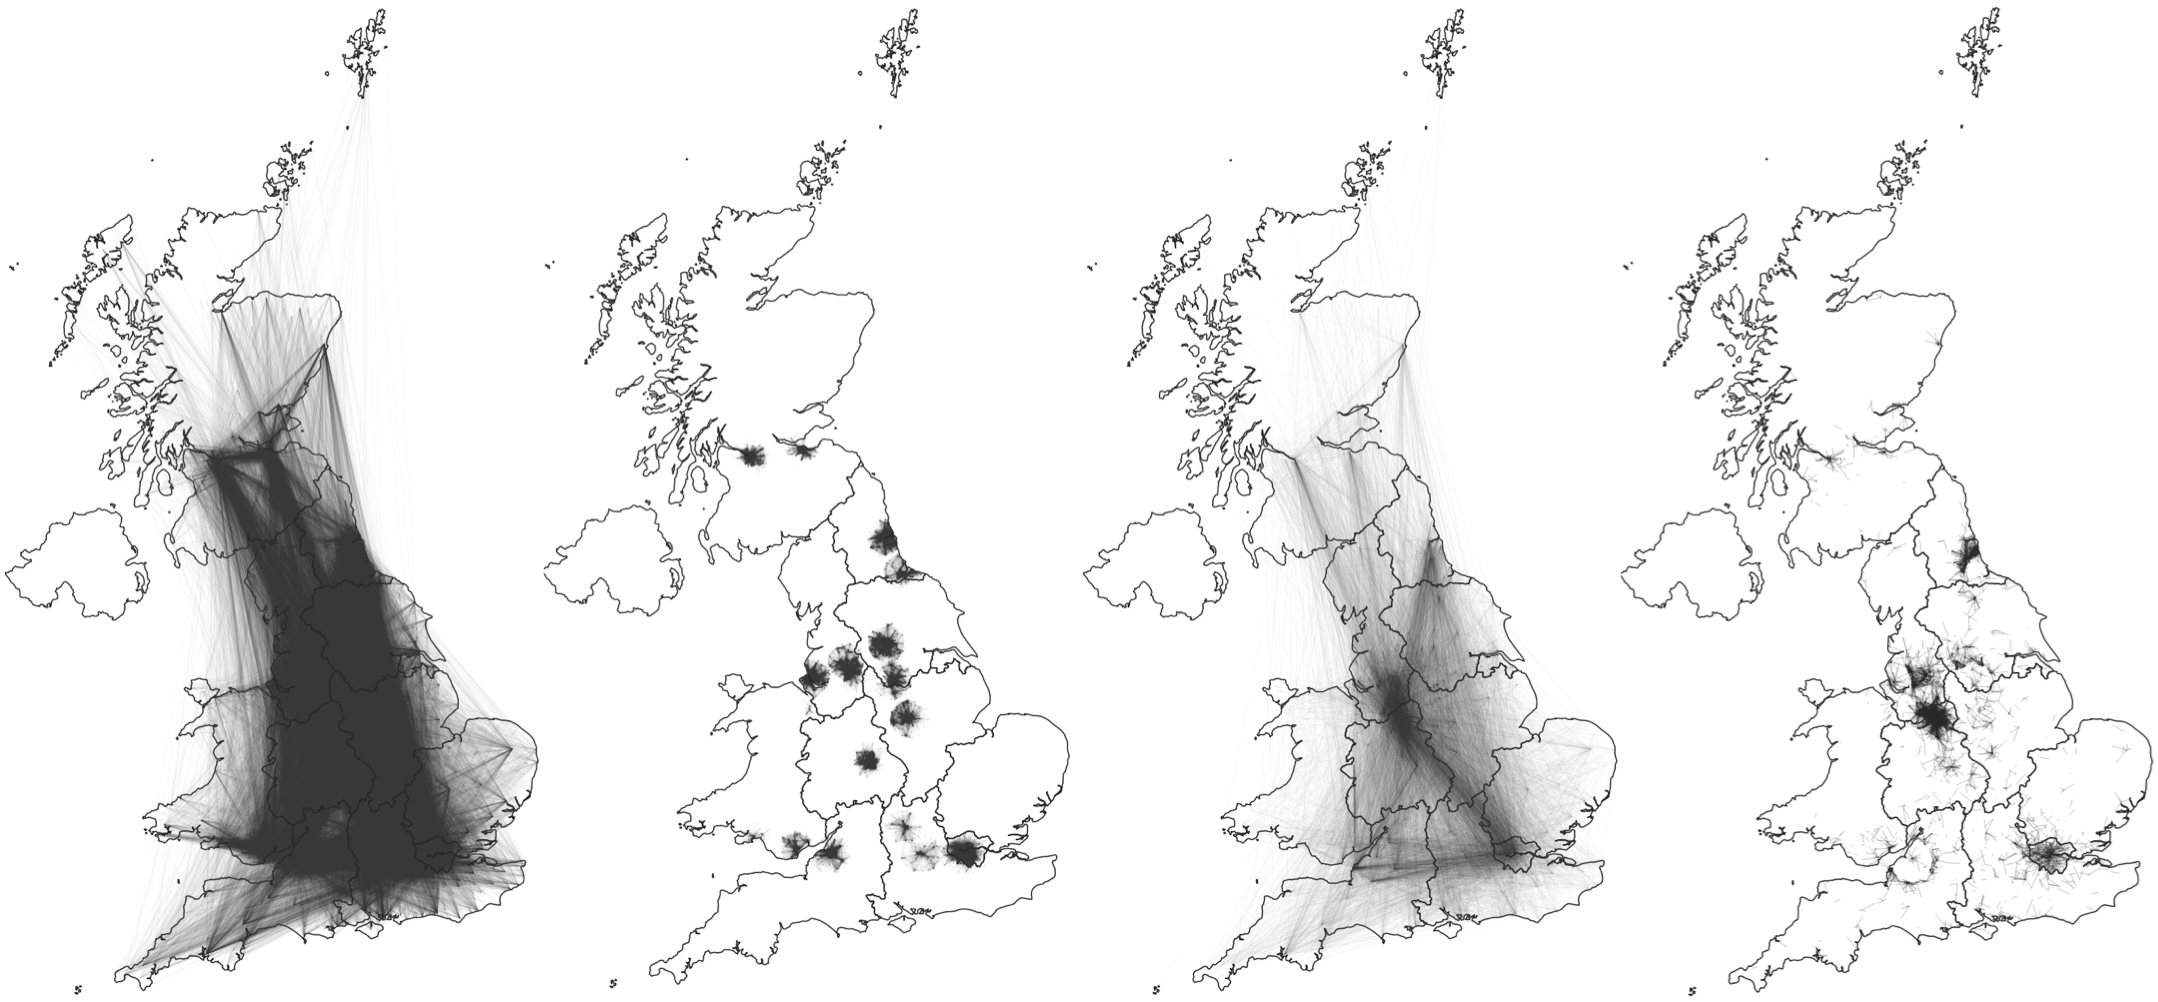

In [11]:
Image(filename='../01_images_figures/movers_stayers_20km.png',width=800) 

# Correlations: Health and phenotype --- Migration

In [12]:
# plotting some health/phenotype data (v2.0)
# have four kinds of phenotype files: categories, stratified, continuous, integer
!ls ../00_csv_files/pheno_*

../00_csv_files/pheno_cat.csv        ../00_csv_files/pheno_int.csv
../00_csv_files/pheno_cont.csv       ../00_csv_files/pheno_strat.csv
../00_csv_files/pheno_fieldNames.csv


### Categorical and Stratified Data

In [22]:
# categorical data (cat) )
pheno_cat = pd.read_csv('../00_csv_files/pheno_cat.csv')
pheno_cat.sample(3)

,eid,Type of accommodation lived in,Own or rent accommodation lived in,Breastfed as a baby,Comparative body size at age 10,Comparative height size at age 10,Weight change compared with 1 year ago,Leisure social activities,Alcohol drinker status
218304,1582710,1.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0
397705,5365429,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
32704,2106126,1.0,1.0,0.0,2.0,2.0,2.0,1.0,2.0


In [23]:
# stratified data (strat)
pheno_strat = pd.read_csv('../00_csv_files/pheno_strat.csv')
pheno_strat.sample(3)

,eid,Alcohol intake frequency,Overall health rating,Hair-balding pattern,Noisy workplace,Loud music exposure frequency,Average total household income before tax,Getting up in morning,Variation in diet,Able to confide,Work-job satisfaction,Health satisfaction,Family relationship satisfaction,Friendships satisfaction,Financial situation satisfaction,Qualifications,Work hours - lumped category
469273,5693757,4.0,4.0,NaN,0.0,0.0,3.0,4.0,1.0,5.0,NaN,6.0,6.0,6.0,5.0,2.0,NaN
481139,5812433,3.0,3.0,NaN,0.0,0.0,4.0,4.0,1.0,4.0,5.0,4.0,6.0,6.0,6.0,4.0,NaN
269584,3696424,2.0,3.0,3.0,0.0,0.0,2.0,3.0,1.0,1.0,NaN,4.0,5.0,4.0,5.0,3.0,NaN


In [24]:
# integer data
pheno_int = pd.read_csv('../00_csv_files/pheno_int.csv')
pheno_int.sample(3)

,eid,Year of birth,Hand grip strength (left),Hand grip strength (right),Number of self-reported cancers,Number of self-reported non-cancer illnesses,Number of operations,Number of treatments-medications taken,Distance between home and job workplace,Sleep duration,Fluid intelligence score,Number of jobs held,Traffic intensity on the nearest road,Traffic intensity on the nearest major road
231150,3311947,1960,30.0,36.0,0.0,0.0,2.0,0.0,30.0,7.0,NaN,NaN,500.0,16910.0
38676,1386848,1966,37.0,21.0,0.0,3.0,1.0,7.0,NaN,14.0,NaN,NaN,500.0,10444.0
404144,5042307,1950,32.0,26.0,0.0,0.0,1.0,0.0,NaN,8.0,NaN,4.0,500.0,14998.0


In [25]:
# continuous data
pheno_cont = pd.read_csv('../00_csv_files/pheno_cont.csv')
pheno_cont.sample(3)

,eid,Waist circumference,Hip circumference,Pack years of smoking,Body mass index (BMI),Weight,Summed MET minutes per week for all activity,Nitrogen dioxide air pollution 2010,Nitrogen oxides air pollution 2010,Particulate matter air pollution pm2-5 2010,Particulate matter air pollution 2-5_10um 2010,Inverse distance to the nearest major road,height
289339,3893981,116.0,121.0,9.00,34.0412,126.8,2640.0,26.59,45.74,12.75,9.60,0.01000,NaN
85426,1854467,116.0,127.0,21.75,36.1433,100.8,5964.0,21.35,32.08,8.86,5.64,0.00250,NaN
334796,4348637,97.0,103.0,NaN,25.9043,83.0,735.0,24.95,39.26,10.17,5.86,0.00274,NaN


In [29]:
# collect data for each eidGroup
df = pheno_strat
col = 'Qualifications'
m_to_plot = []

# total number of categories
n = np.unique(df[col])
n = n[~np.isnan(n)]
n = n[np.where(n>=0)]
numCats = len(n)
print(numCats)

# for each eidGroup
for g in eidGroups:
    # collect data in a column
    d = df[df['eid'].isin(g)][col].values
    # ... remove NaN
    d_with_data = d[~np.isnan(d)] 
    # ... remove negative numbers
    d_pos = d_with_data[np.where(d_with_data>=0)]
    print(len(d),len(d_with_data),len(d_pos))
    m_to_plot.append(d_pos)

4
232606 142945 142945
165267 133536 133536
5710 3842 3842
13566 11066 11066


[229898, 162782, 5618, 13231]


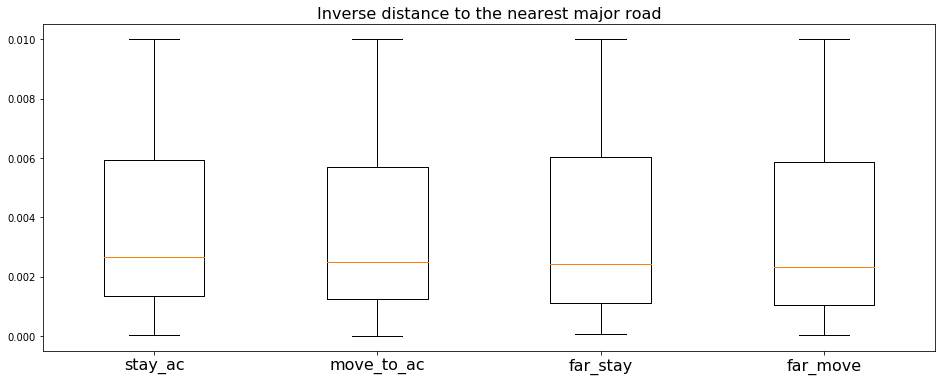

In [27]:
# integer or continuous data: plot as boxplots (or violinplots)
fig, ax = plt.subplots(1,1,figsize=(16,6))

ax.boxplot(m_to_plot,showfliers=False)
#ax.boxplot(m_to_plot)
#ax.violinplot(m_to_plot)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(grouplabels,fontsize=16)
ax.set_title(col,fontsize=16)

print([len(x) for x in m_to_plot])

plt.show()

[142945, 133536, 3842, 11066]


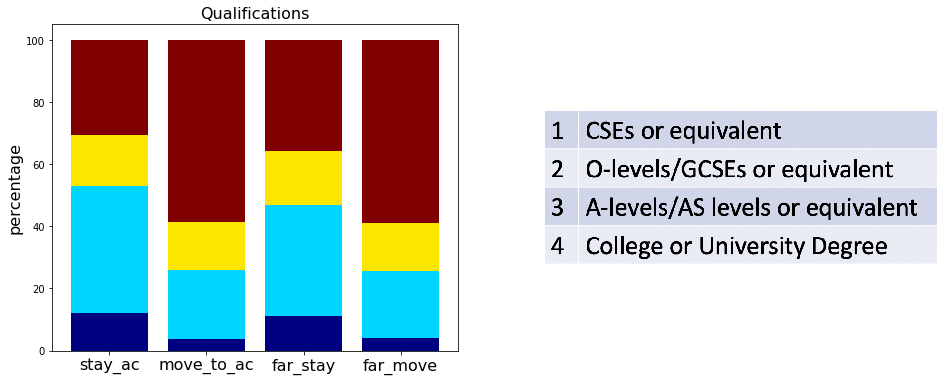

In [30]:
# categorized or stratified data: plot as stacked bars of percentages
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,6))

plotVals = []
cols = get_ncolors_from_cmap(numCats,colormap='jet')

table_for_stats = []

for i,m in enumerate(m_to_plot):
    labels, counts = np.unique(m, return_counts=True)
    percentages = [x/np.sum(counts)*100 for x in counts]
    table_for_stats.append(counts)
    bot = 0
    for j,p in enumerate(percentages):
        ax.bar(i+1, p , align='center', bottom=bot, color=cols[j])
        bot = bot + p

ax.set_ylabel('percentage',fontsize=16)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(grouplabels,fontsize=16)
ax.set_title(col,fontsize=16)

fname = col + '.png'
#fname = 'Leisure social activities.png'
img=mpimg.imread('../05_pheno_codes/' + fname)
ax2.imshow(img)
ax2.set_axis_off()

print([len(x) for x in m_to_plot])

plt.show()

In [31]:
# do chi-square test
s = []
print('with low vals')
for t in table_for_stats:
    print(t)
    s.append(t[0:4])
    
print('without low vals')
for r in s:
    print(r)

with low vals
[17483 58127 23577 43758]
[ 5112 29595 20656 78173]
[ 431 1366  668 1377]
[ 457 2391 1702 6516]
without low vals
[17483 58127 23577 43758]
[ 5112 29595 20656 78173]
[ 431 1366  668 1377]
[ 457 2391 1702 6516]


In [32]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(table_for_stats)
print("Chi2 Stat         ",chi2_stat)
print("Degrees of Freedom",dof)
print("P-Value           ",p_val)
print("===Contingency Table===")
print(ex)

Chi2 Stat          26936.67855643701
Degrees of Freedom 9
P-Value            0.0
===Contingency Table===
[[11519.91816781 44876.31878691 22861.76154556 63687.00149971]
 [10761.64813359 41922.44643415 21356.94280841 59494.96262385]
 [  309.62625906  1206.16192787   614.46631822  1711.74549485]
 [  891.80743954  3474.07285107  1769.82932781  4930.29038159]]


## First pass (old) looking at some health/phenotype data from the UKB

try Frequency of friend/family visits = column 16, 1031-0.0  (not much)
column 19, 1160-0.0, Sleep duration
file:///Users/iwoods/Dropbox/sabbatical2019/por_healthdata/ukb27538.html  
to make this file:   
cut -d',' -f1,17 ukb27538.csv > d.csv

### Age

In [106]:
# get ages
eid_data = pd.read_csv('../00_csv_files/eid_data.csv')
eid_data.head(2)

,eid,center,DOB,POB_north,POB_east,POB_NUTSID,POB_gridID,POR_east,POR_north,POR_NUTSID,POR_gridID
0,1136349,11004,1947,801500,68500,UKM64,774,252000.0,663000.0,UKM34,3106
1,1071275,11004,1952,798500,66500,UKM64,775,211000.0,665000.0,UKM63,2618


In [107]:
# make dictionary age[eid]=yearsold
eids = eid_data['eid'].values.tolist()
dobs = eid_data['DOB'].values.tolist()
ages = [2010-x for x in dobs]
age = dict(zip(eids,ages))

In [108]:
# save ages to file
# with open('../00_csv_files/d.csv','w') as o:
#     o.write('eid,age\n')
#     for eid in sorted(age.keys()):
#         o.write(str(eid) + ',' + str(age[eid]) + '\n')
# o.close()

In [147]:
# make temporary file from specific column of ukb27538.csv
!cut -d',' -f1,8 ../00_csv_files/ukb27538.csv > ../00_csv_files/d.csv
!head -10 ../00_csv_files/d.csv

"eid","738-0.0"
"3609487","2"
"1194904","5"
"1391300","3"
"4000122","2"
"4368424","4"
"5591624","1"
"3278908","5"
"1783089","4"
"4399066","3"


62163
43647
6647
3066


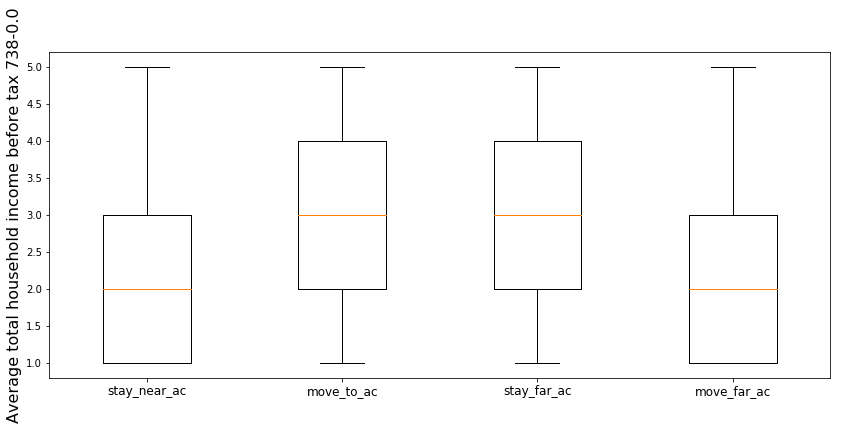

In [165]:
comp = 'Average total household income before tax 738-0.0'

toPlot = 4 # 8 for all 8 categories; 4 for stay_near_ac; move_to_ac; stay_far_ac; move_far_ac

# make dictionary: d[eid]=>val
d={}
with open('../00_csv_files/d.csv','r') as f:
    header = f.readline()
    for line in f:
        stuff = line.rstrip().replace('"','').split(',')
        eid = int(stuff[0])
        try:
            val = float(stuff[1])
            if val > 0:
                d[eid] = val
        except:
            pass

# make a matrix for a boxplot
m = []
eidsWithVals = []
for g in eidGroups:
    vals = [d[eid] for eid in g if eid in d.keys()]
    e = [eid for eid in g if eid in d.keys()]
    m.append(vals)
    eidsWithVals.append(e)
eidGroups = eidsWithVals

if toPlot == 8:
    labs = ['close_move','close_stay','pob_close_move','pob_close_stay','por_close_move','por_close_stay',
       'far_move','far_stay']
    m_to_plot = m
elif toPlot == 4:
    labs = ['stay_near_ac', 'move_to_ac', 'move_far_ac', 'stay_far_ac']
    m_to_plot = [m[1],m[4],m[6],m[7]]
    
fig, ax = plt.subplots(figsize=(14,6))
pos = np.arange(len(m_to_plot)) + 1

#ax.violinplot(m_to_plot,pos,showmedians = True)
ax.boxplot(m_to_plot,showfliers=False)
#ax.boxplot(m_to_plot)
ax.set_xticks(pos)
ax.set_xticklabels(labs,fontsize=12)
ax.set_ylabel(comp,fontsize=16)
for x in m_to_plot:
    print(len(x))
plt.show()

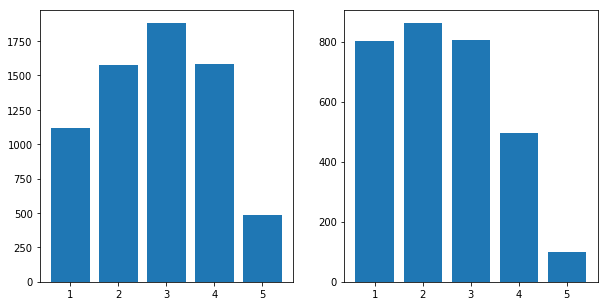

In [162]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
arr=m_to_plot[2]
labels, counts = np.unique(arr, return_counts=True)
ax1.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)

arr=m_to_plot[3]
labels, counts = np.unique(arr, return_counts=True)
ax2.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)

plt.show()

In [149]:
col1,col2 = 0,1
s,p = stats.kruskal(m[0],m[1],m[2],m[3])
print('kruskal: ',p)
s,p = stats.mannwhitneyu(m[col1],m[col2],alternative='less')
print('mann-whitney-u less: ',p)
s,p = stats.mannwhitneyu(m[col1],m[col2],alternative='greater')
print('mann-whitney-u greater: ',p)

kruskal:  9.421307712766022e-58
mann-whitney-u less:  1.0
mann-whitney-u greater:  3.5176418723420194e-60


## Scatter and regression

66373 9713


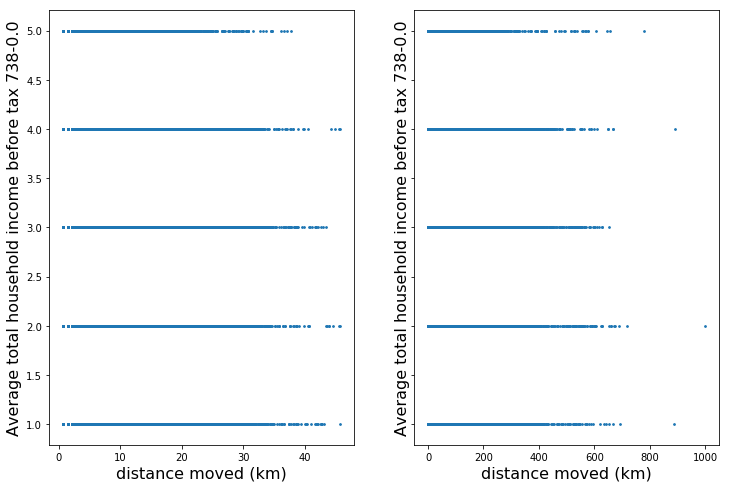

In [153]:
# scatter ... por and pob within threshold OR pob and por outside of threshold
# move vs. vals
# regression line
close_eids = eidGroups[0] + eidGroups[1]
far_eids = eidGroups[6] + eidGroups[7]
#print(len(close_eids),len(far_eids))

close_vals = m[0] + m[1]
far_vals = m[6]+m[7]
#print(len(close_vals),len(far_vals))

close_moves = pob_por[pob_por['eid'].isin(close_eids)]['distances']/1000
far_moves = pob_por[pob_por['eid'].isin(far_eids)]['distances']/1000
#print(len(close_moves),len(far_moves))


f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)

ax1.scatter(close_moves,close_vals,s=3)
ax1.set_ylabel(comp,fontsize=16)
ax1.set_xlabel('distance moved (km)',fontsize=16)

ax2.scatter(far_moves,far_vals,s=3)
ax2.set_ylabel(comp,fontsize=16)
ax2.set_xlabel('distance moved (km)',fontsize=16)

print(len(close_moves), len(far_moves))

plt.show()


## Net change in distance to assessment center, POB vs POR

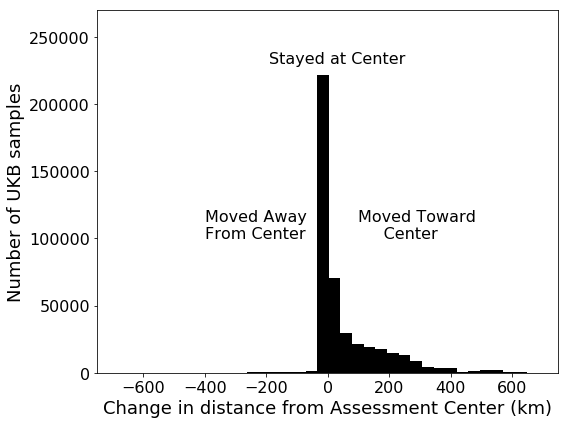

In [51]:
netChangeACDistance = (pob_por['POB_distance'] - pob_por['POR_distance'])/1000
fig,ax2 = plt.subplots(figsize=(8,6))
ax2.hist(netChangeACDistance,50,color='k')
ax2.set_ylabel('Number of UKB samples',fontsize=18)
ax2.set_xlabel('Change in distance from Assessment Center (km)',fontsize=18)
ax2.set_xlim([-750,750])
ax2.set_ylim([0,270000])
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.text(-190,230000,'Stayed at Center',fontsize=16)
ax2.text(100,100000,'Moved Toward\n     Center',fontsize=16)
ax2.text(-400,100000,'Moved Away\nFrom Center',fontsize=16)
plt.tight_layout()
plt.savefig('../07_figures/Figure_01_sampling_AC/pob_por_center_movement.png', dpi=150)
plt.show()

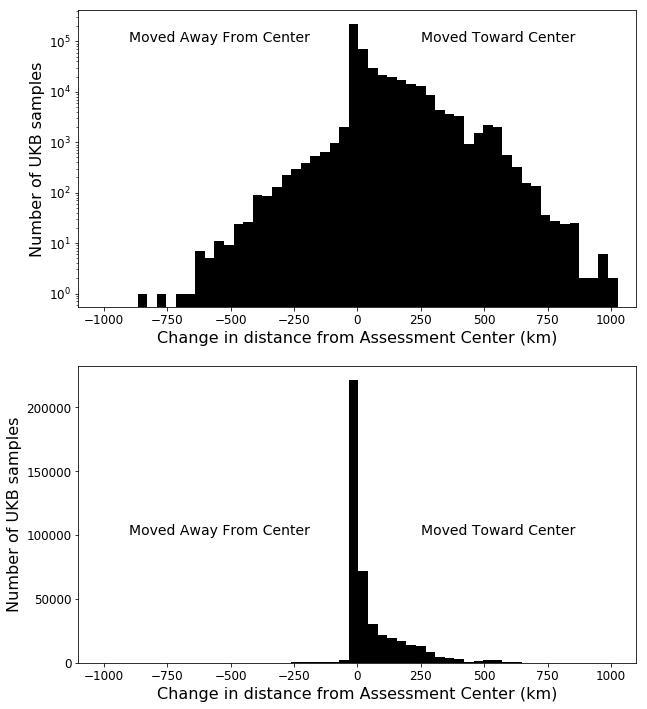

In [27]:
netChangeACDistance = (pob_por['POB_distance'] - pob_por['POR_distance'])/1000
fig,(ax,ax2) = plt.subplots(2,1,figsize=(10,12))
ax.hist(netChangeACDistance,50,color='k')
ax.set_ylabel('Number of UKB samples',fontsize=16)
ax.set_xlabel('Change in distance from Assessment Center (km)',fontsize=16)
ax.set_xlim([-1100,1100])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(250,100000,'Moved Toward Center',fontsize=14)
ax.text(-900,100000,'Moved Away From Center',fontsize=14)


ax2.hist(netChangeACDistance,50,color='k')
ax2.set_ylabel('Number of UKB samples',fontsize=16)
ax2.set_xlabel('Change in distance from Assessment Center (km)',fontsize=16)
ax2.set_xlim([-1100,1100])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.text(250,100000,'Moved Toward Center',fontsize=14)
ax2.text(-900,100000,'Moved Away From Center',fontsize=14)
     
plt.show()

# OLD - adding POB/POR assessment center distances to eid_data

In [96]:
# find POR and POB assessment center distances 
por_distance = np.zeros(len(pob_por))
pob_distance = np.zeros(len(pob_por))
for i,r in pob_por.iterrows():
    centerCoord = ac_coords[r['center']]
    pob_coord = [r['POB_east'],r['POB_north']]
    por_coord = [r['POR_east'],r['POR_north']]
    por_distance[i] = coords_to_distance(centerCoord,por_coord)
    pob_distance[i] = coords_to_distance(centerCoord,pob_coord)

In [98]:
pob_por['POB_distance'] = pob_distance
pob_por['POR_distance'] = por_distance
# hates this when start with eid_data: "A value is trying to be set on a copy of a slice from a DataFrame."

In [199]:
# add POB-to-POR distance
distances = np.zeros(len(pob_por))
for i,r in pob_por.iterrows():
    pob_coord = [r['POB_east'],r['POB_north']]
    por_coord = [r['POR_east'],r['POR_north']]
    distances[i] = coords_to_distance(pob_coord,por_coord)

In [200]:
# rearrange column order, and save
pob_por['distances'] = distances

In [202]:
br = pob_por[['eid','center','distances','POB_east','POB_north','POR_east','POR_north','POB_distance',
             'POR_distance']]
br.head(2)

,eid,center,distances,POB_east,POB_north,POR_east,POR_north,POB_distance,POR_distance
0,1136349,11004,229901.065678,68500,801500,252000.0,663000.0,234227.018930,7490.487100
1,1071275,11004,196729.509734,66500,798500,211000.0,665000.0,234138.707601,48107.415198


In [203]:
br.to_csv('../00_csv_files/pob_por_ac_distances.csv',index=False)

# data prep
make csv files of different types of data: continuous, integer, stratified, categorical  
See https://docs.google.com/spreadsheets/d/1JAwGhFTE0Rmx3bjfHMUSyB-ifY9-Kvrlt-xr_UrVcKY/edit#gid=1050825066  
for desired categories  

See ukb27538_fieldNames.csv and pheno_fieldNames.csv for field codes and descriptions   
  (e.g. 670-0.0,501673,Categorical (single),Type of accommodation lived in)

In [160]:
# column codes and descriptions to dict . . .  
column_codes = {}

def get_descriptions(d,fname):
    with open(fname,'r') as f:
        for line in f:
            stuff = line.rstrip().split(',')
            d[stuff[1]] = stuff[4]
    return d
        
f1 = '../00_csv_files/ukb27538_fieldNames.csv'
column_codes = get_descriptions(column_codes,f1)
f2 = '../00_csv_files/pheno_fieldNames.csv'
column_codes = get_descriptions(column_codes,f2)

In [ ]:
## cutting and copying
# cut -d',' -f1,2,5,35,38,41,50,86,104 ../00_csv_files/ukb27538.csv > health_demo_cat.csv
# cut -d',' -f1,111,219,220,221,222,225 ../00_csv_files/ukb27538.csv > health_demo_cont.csv
# cut -d',' -f1,14,20,101,107,112,113,223,224 ../00_csv_files/ukb27538.csv > health_demo_int.csv
# cut -d',' -f1,8,16,20,23,26,29,44,47,53,56,59,62,65,68,114 ../00_csv_files/ukb27538.csv > health_demo_strat.csv

# from pheno.csv (on cbsu)
# cut -d',' -f1,10,13,1291,1300,1303 pheno.csv > ../ian/pheno_cont.csv
# cut -d',' -f1,3,4,7,29,32,35,38 pheno.csv > ../ian/pheno_int.csv
# cut -d',' -f1,42,51,93,225,228 pheno.csv > ../ian/pheno_strat.csv

# copying from cbsu
# scp igw9@cbsulogin.tc.cornell.edu:/bscb/bscb09/500k_ukb/ian/pheno_cont.csv .
# etc . . . 

In [161]:
# function to name columns from field code (e.g. 670.0.0) to field description (e.g. Type of accommodation lived in)
def cols_rename_fieldCode_fieldName(df,column_codes):
    replacements = []
    cols = df.columns.values.tolist()
    for c in cols:
        if c in column_codes.keys() and c != 'eid':
            replacements.append(column_codes[c])
        else:
            replacements.append(c)

    replacedColumns = dict(zip(cols,replacements))
    
    df2 = df.rename(index=str, columns = replacedColumns)
    return df2
    

In [246]:
# merging and cleaning up column names
ph = pd.read_csv('../pheno/pheno_int.csv')
hd = pd.read_csv('../health_demo/health_demo_int.csv')

In [247]:
# change the column names from field codes to field descriptions
df3 = cols_rename_fieldCode_fieldName(ph,column_codes)
print(len(df3))
df3.head(3)

502641


,eid,Year of birth,Hand grip strength (left),Hand grip strength (right),Number of self-reported cancers,Number of self-reported non-cancer illnesses,"""Number of operations",Number of treatments/medications taken
0,1000015,1951,30.0,28.0,0.0,0.0,0.0,0.0
1,1000027,1955,48.0,44.0,0.0,1.0,0.0,1.0
2,1000039,1966,10.0,10.0,0.0,0.0,0.0,0.0


In [248]:
# df3.rename(index=str,columns={'Number of treatments/medications taken':'Number of treatments-medications taken',
#                              '"Number of operations':'Number of operations'},inplace=True)

In [249]:
#df3.to_csv('../pheno/pheno_int.csv',index=False)

In [250]:
df3.sample(5)

,eid,Year of birth,Hand grip strength (left),Hand grip strength (right),Number of self-reported cancers,Number of self-reported non-cancer illnesses,Number of operations,Number of treatments-medications taken
375969,4759704,1939,29.0,27.0,0.0,0.0,0.0,0.0
19325,1193264,1961,44.0,44.0,0.0,2.0,1.0,3.0
86659,1866602,1963,42.0,34.0,0.0,0.0,3.0,0.0
440758,5407594,1952,26.0,26.0,1.0,5.0,7.0,3.0
159052,2590538,1959,21.0,23.0,0.0,0.0,2.0,1.0


In [254]:
df4 = cols_rename_fieldCode_fieldName(hd,column_codes)
print(len(df4))
df4.sample(5)

502536


In [256]:
# join the two dataframes
df5 = df3.merge(df4,on='eid')
df5.sample(10)

,eid,Year of birth,Hand grip strength (left),Hand grip strength (right),Number of self-reported cancers,Number of self-reported non-cancer illnesses,Number of operations,Number of treatments-medications taken,Distance between home and job workplace,Sleep duration,Fluid intelligence score,Ethnic background,Number of jobs held,Traffic intensity on the nearest road,Traffic intensity on the nearest major road
190858,2908982,1947,23.0,26.0,1.0,0.0,3.0,2.0,4.0,6.0,NaN,1001.0,NaN,500.0,55184.0
251887,3519370,1964,36.0,40.0,0.0,0.0,1.0,0.0,60.0,7.0,NaN,1001.0,3.0,500.0,15905.0
242351,3423985,1947,40.0,40.0,0.0,3.0,2.0,4.0,9.0,7.0,NaN,1001.0,NaN,500.0,9249.0
312996,4130593,1945,30.0,32.0,0.0,2.0,0.0,5.0,3.0,7.0,NaN,1001.0,NaN,500.0,15560.0
122782,2228063,1941,24.0,24.0,0.0,0.0,2.0,0.0,NaN,8.0,NaN,1001.0,NaN,13254.0,13254.0
129200,2292261,1961,42.0,46.0,0.0,0.0,0.0,1.0,2.0,8.0,NaN,1001.0,2.0,500.0,11790.0
332653,4327181,1941,24.0,26.0,0.0,4.0,2.0,4.0,NaN,8.0,NaN,1001.0,NaN,500.0,12783.0
380629,4807081,1944,42.0,42.0,0.0,1.0,2.0,0.0,5.0,7.0,NaN,1001.0,NaN,500.0,10893.0
459068,5591689,1944,26.0,24.0,0.0,0.0,2.0,0.0,6.0,8.0,NaN,1001.0,NaN,500.0,90926.0
319099,4191630,1944,36.0,38.0,0.0,0.0,1.0,0.0,NaN,7.0,7.0,1001.0,NaN,500.0,11504.0


In [194]:
#df5.rename(index=str,columns={'Hair/balding pattern':'Hair-balding pattern'},inplace=True)
#df5.drop(columns='Sleep duration', inplace=True)

In [257]:
# save the dataframe
print(len(df5))
df5.to_csv('../00_csv_files/pheno_int.csv',index=False)

502536


In [245]:
# only health_demo has 'cat' data
hd = pd.read_csv('../health_demo/health_demo_cat.csv')
df4 = cols_rename_fieldCode_fieldName(hd,column_codes)
print(len(df4))
df4.head(3)

502536


,eid,Type of accommodation lived in,Own or rent accommodation lived in,Breastfed as a baby,Comparative body size at age 10,Comparative height size at age 10,Weight change compared with 1 year ago,Leisure/social activities,Alcohol drinker status
0,3609487,1.0,1.0,1.0,2.0,2.0,0.0,1.0,2.0
1,1194904,1.0,2.0,-1.0,2.0,2.0,0.0,1.0,2.0
2,1391300,1.0,1.0,1.0,2.0,3.0,0.0,-7.0,2.0


In [246]:
df4.to_csv('../00_csv_files/pheno_cat.csv',index=False)

### Add height to pheno_cont dataset

In [ ]:
# there are only 37,090 datapoints here
# http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=12144
# sitting height has much more: 497,162 
# http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=20015

In [6]:
pheno_cont = pd.read_csv('../00_csv_files/pheno_cont.csv')
pheno_cont.head(5)

,eid,Waist circumference,Hip circumference,Pack years of smoking,Body mass index (BMI),Weight,Summed MET minutes per week for all activity,Nitrogen dioxide air pollution 2010,Nitrogen oxides air pollution 2010,Particulate matter air pollution pm2-5 2010,Particulate matter air pollution 2-5_10um 2010,Inverse distance to the nearest major road
0,1000015,96.0,89.0,NaN,25.3515,75.0,11358.0,40.57,75.75,NaN,NaN,0.00990
1,1000027,89.0,106.0,NaN,27.8268,99.4,1830.0,14.40,22.99,8.49,5.91,0.01000
2,1000039,96.0,115.0,NaN,33.4186,73.2,693.0,35.61,63.43,11.24,6.55,0.00553
3,1000040,65.0,90.0,31.875,18.3203,58.7,NaN,13.12,19.97,8.17,6.11,0.00048
4,1000053,70.5,93.0,NaN,18.2969,63.3,5733.0,20.36,28.53,8.96,6.01,0.00110


In [5]:
pheno_cont.to_csv('../00_csv_files/pheno_cont.csv',index=False)

In [ ]:
# from pheno.csv (on cbsu)
# cut -d',' -f1,539 pheno.csv > ../ian/pheno_height.csv

# copy to local
# scp igw9@cbsulogin.tc.cornell.edu:/bscb/bscb09/500k_ukb/ian/pheno_height.csv .

In [8]:
height = pd.read_csv('../pheno/pheno_height.csv')
height.rename(index=str,columns={'12144-2.0':'height'},inplace=True)

In [9]:
height.head(2)

,eid,height
0,1000015,NaN
1,1000027,NaN


In [10]:
t = pheno_cont.merge(height, on='eid')

In [12]:
t.to_csv('../00_csv_files/pheno_cont.csv',index=False)